In [51]:
# NUMPY & PANDAS
import numpy as np
import pandas as pd

# MATPLOTLIB
import matplotlib.pyplot as plt

# SCI_KIT LEARN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# SHOGUN
from shogun import *

from time import time

###### READ THE CSV FILE 

In [52]:
df = pd.read_csv('../data/nyc-sales.csv')
df.head()






,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [53]:
#Data Preprocessing

for i in range(len(df)):
    if(df.loc[i,'SALE PRICE'] == ' -  '):
        df.at[i,'SALE PRICE'] = np.nan
        

#train is the cleaned data
df_train = df[df['SALE PRICE'].notna()]

# Separate target var
col_x = [col for col in df.columns
      if col != 'SALE PRICE']
      
X = df_train[col_x] #Training set


# target variable
target = ['SALE PRICE']

y= df_train[target] #Training targets

encoder = LabelEncoder()

s = (X.dtypes == 'object')

cat_vars = list(s[s].index)

# drop the unwanted columns
X = X.drop(columns=['Unnamed: 0','NEIGHBORHOOD','ADDRESS','EASE-MENT',
                              'BUILDING CLASS CATEGORY','SALE DATE','APARTMENT NUMBER'])
                             

s = (X.dtypes == 'object')
cat_varsx = list(s[s].index)

#  Labeling properly the columns with object data type
le = LabelEncoder()

num_X= X.copy()
for col in cat_varsx:
    num_X[col] = le.fit_transform(X[col])
    
# Convert features and labels suitable for shogun

num_X= num_X.to_numpy().astype(float)  
y= y.to_numpy().astype(float)
y= y.reshape(y.shape[0],) #reshape to (num_samples,)


X_train, X_test, y_train, y_test = train_test_split(num_X, y, test_size=0.33, random_state=42)

# X_test.shape

In [54]:
#Parameters for plotting
time_skl = []
time_sgn = []
time_diff = []
size = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
error_skl=[]
error_sgn=[]

In [55]:

for m in size:
    
    print(m)

#SKLEARN

    X_train_temp = X_train[:m]
    y_train_temp = y_train[:m]
    skr = KernelRidge(kernel='rbf', gamma=0.1)

    t0 = time()
    skr.fit(X_train_temp, y_train_temp)
    tsk1 = time() - t0

    #Apply to test
    y_predict = skr.predict(X_test) #Test on the entire test set
    error_skl.append(mean_squared_error(y_test,y_predict,squared=True))#Get error
    
    time_skl.append(tsk1)


#SHOGUN        
    train_features = RealFeatures(X_train_temp.T)
    labels_train = RegressionLabels(y_train_temp)

    width = 0.1
    kernel = GaussianKernel(train_features, train_features, width)
    tau = 1
    krr = KernelRidgeRegression(tau, kernel, labels_train)

    t0=time()
    krr.train()
    tsg1=time()-t0

    #Apply to test
    labels_predict = krr.apply_regression(RealFeatures(X_test.T))
    error_sgn.append(mean_squared_error(y_test,labels_predict.get_labels(),squared=True)) #get error
    

    time_sgn.append(tsg1)
   
    #Final remarks
    
    print("Sklearn time: " + str(tsk1))
    print("Shogun time: " + str(tsg1))
    print("SKL Accuracy: " + str(mean_squared_error(y_test,y_predict,squared=False)))
    print("Shogun Accuracy: " + str(mean_squared_error(y_test,labels_predict.get_labels(),squared=False)))
    print("\n")


1000
Sklearn time: 0.09116482734680176
Shogun time: 0.15205788612365723
SKL Accuracy: 15571108.076778537
Shogun Accuracy: 15572687.027265174


2000
Sklearn time: 0.366013765335083
Shogun time: 0.6535770893096924
SKL Accuracy: 15567980.831106262
Shogun Accuracy: 15572483.959390316


3000
Sklearn time: 0.788646936416626
Shogun time: 1.9397077560424805
SKL Accuracy: 15567344.50320614
Shogun Accuracy: 15572274.418999676


4000
Sklearn time: 1.5846755504608154
Shogun time: 4.260968208312988
SKL Accuracy: 15564029.258770406
Shogun Accuracy: 15572002.488203676


5000
Sklearn time: 2.386605739593506
Shogun time: 7.113086223602295
SKL Accuracy: 15561470.017019505
Shogun Accuracy: 15571722.302678261


6000
Sklearn time: 3.7806503772735596
Shogun time: 11.085485696792603
SKL Accuracy: 15558712.483802943
Shogun Accuracy: 15571635.055209877


7000
Sklearn time: 5.470291376113892
Shogun time: 16.339040517807007
SKL Accuracy: 15558490.30669556
Shogun Accuracy: 15571855.167597314


8000
Sklearn time: 

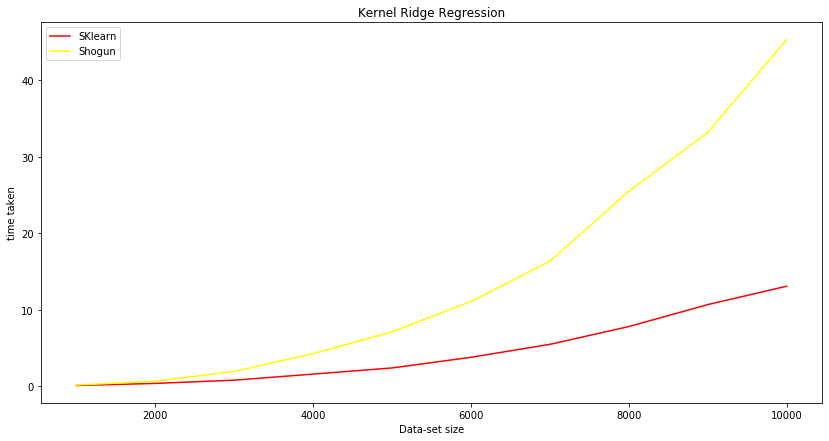

In [56]:
# PLOTTING Time_taken
plt.figure(figsize=(14,7))
plt.title('Kernel Ridge Regression')
plt.plot(size,time_skl,color='red',label='SKlearn')
plt.plot(size,time_sgn,color='yellow',label='Shogun')
plt.xlabel('Data-set size')
plt.ylabel('time taken')
plt.legend()

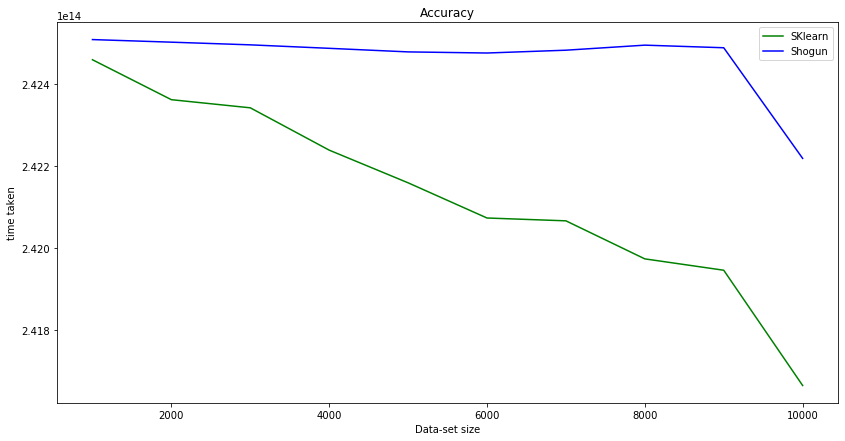

In [57]:
# PLOTTING Accuracy
plt.figure(figsize=(14,7))
plt.title('Accuracy')
plt.plot(size,error_skl,color='green',label='SKlearn')
plt.plot(size,error_sgn,color='blue',label='Shogun')
plt.xlabel('Data-set size')
plt.ylabel('time taken')
plt.legend()